# Sheet7 Leonhard Moske


In [54]:
import numpy as np
import itertools as it
import sympy

def pullGaussWfFactors(mean, std, N):
    return np.random.normal(mean, std, N)

def genBasis(L, s): #L number of spins, s total spin
    posSpins = np.linspace(-s, s, int((2*s+1)), dtype = float)#generate List of all possible z projections
    #print("possible Spins ", posSpins)
    tmp = it.product(posSpins, repeat = L) # generate object that itterates over all combinations
    return np.asarray([i for i in tmp]) # assemble the list


def Splus(oldcoef, state, site, s): # site counted from 0 as tupel , passed with copy
                        # return new coefficient and new state 
    if (state[site] >= s): # if state is s the operator will return 0
        return 0, np.zeros(state.shape)
    coef = np.sqrt(s*(s+1) - state[site] * (state[site] + 1)) #calculate new coef
    state[site] = state[site] + 1 # update spin state
    return coef*oldcoef, state 

def Sminus(oldcoef, state, site, s): # analog to Splus
    if (state[site] <= -s ):
        return 0, np.zeros(state.shape)
    coef = np.sqrt(s*(s+1) - state[site] * (state[site] - 1))
    state[site] = state[site] - 1
    return coef*oldcoef, state 

def Sz(coef, state, site): 
    return state[site]*coef, state

def Hamiltonian(statei , statej, s, J, Lx, Ly):
    H = 0
    for i in range(Lx*Ly): #apply the operators to every site in x direction
        # print("index,",i)
        if i%Lx == 0:
            # print("x Bounds",i, i+Lx-1)
            coef1, state1 = Splus(*Sminus(1, np.copy(statei), i+Lx-1, s), i, s)
            coef2, state2 = Sminus(*Splus(1, np.copy(statei), i+Lx-1, s), i, s)
            coef3, state3 = Sz(*Sz(1, np.copy(statei), i+Lx-1), i)
            if np.array_equal(state1, statej): #compare if (<i|H)|j> is 0 for every term
                H += coef1*J*0.5
            if np.array_equal(state2, statej):
                H += coef2*J*0.5
            if np.array_equal(state3, statej):
                H += coef3 * J
        else:
            # print("x normal", i, i-1)
            coef1, state1 = Splus(*Sminus(1, np.copy(statei), i-1, s), i, s)
            coef2, state2 = Sminus(*Splus(1, np.copy(statei), i-1, s), i, s)
            coef3, state3 = Sz(*Sz(1, np.copy(statei), i-1), i)
            if np.array_equal(state1, statej): #compare if (<i|H)|j> is 0 for every term
                H += coef1*J*0.5
            if np.array_equal(state2, statej):
                H += coef2*J*0.5
            if np.array_equal(state3, statej):
                H += coef3 * J
        # apply in y direction
        coef1, state1 = Splus(*Sminus(1, np.copy(statei), i-Lx, s), i, s)
        coef2, state2 = Sminus(*Splus(1, np.copy(statei), i-Lx, s), i, s)
        coef3, state3 = Sz(*Sz(1, np.copy(statei), i-Lx), i)
        if np.array_equal(state1, statej): #compare if (<i|H)|j> is 0 for every term
            H += coef1*J*0.5
        if np.array_equal(state2, statej):
            H += coef2*J*0.5
        if np.array_equal(state3, statej):
            H += coef3 * J
    return H

def calcMatrix(Basis, J, Lx, Ly, s):# calculate the basis by calculating the hamiltonian with all combination from the basis
    Matrix = np.empty((len(Basis),len(Basis)))
    for i, j in it.product(range(len(Basis)), repeat=2):
        # print(i,j)
        Matrix[i,j] = Hamiltonian(Basis[i], Basis[j], s,J, Lx, Ly)
    return Matrix

def totalZ(state, Lx,Ly):
    totalZ = 0
    for i in range(Lx*Ly):
        totalZ += Sz(1, state, i)[0]
    return totalZ

def splitBasisTotZ(Basis, Lx,Ly):
    splitBasis= []
    sortedBasis = sorted(Basis, key = lambda state : (totalZ(state, Lx,Ly)))
    tmpBasis = []
    oldz = totalZ(sortedBasis[0],Lx,Ly)
    for state in sortedBasis:
        z = totalZ(state, Lx,Ly)
        if z != oldz:
            splitBasis.append(tmpBasis)
            tmpBasis = [state]
            oldz = z
        else:
            tmpBasis.append(state)
            oldz = z
    splitBasis.append(tmpBasis)  
    return splitBasis

from scipy.sparse import csr_matrix

def lancoz(A, v_un, m): #A is scipy sparse matrix
    n = len(v_un)
    alpha = np.empty(m)
    beta = np.empty(m)
    v = np.empty((m+1,n))
    v0 = v_un / np.linalg.norm(v_un)
    v[0] = v0
    beta[0] = 0
    w = A.dot(v[0])
    alpha[0] = np.dot(w,v[0])
    w = np.add(w, -1*alpha[0]*v[0])
    beta[1] = np.linalg.norm(w)
    v[1] = w/beta[1]
    for j in range(1,m-1):
        w = np.add(A.dot(v[j]), (-1)*beta[j]*v[j-1])
        alpha[j] =  np.dot(w,v[j])
        w = np.add(w, -1*alpha[j]*v[j]) 
        beta[j+1] = np.linalg.norm(w)
        v[j+1] = w/beta[j+1]
    return v, alpha, beta[1:]

def wrapLancoz(csr_matrix, L, m, v0):
    
    # v0 = np.random.rand(2**L)
    v, alpha, beta = lancoz(csr_matrix, v0, m)

    T = np.zeros((m,m))

    for i in range(m):
        T[i,i] = alpha[i]
    for i in range(m-1):
        T[i,i+1] = beta[i]
        T[i+1,i] = beta[i]

    return T , v

from scipy.linalg import eig, inv


def diagonalizeT(T, beta):
    eVa, eVe = eig(T)

    D = np.zeros(np.shape(T))

    np.fill_diagonal(D, np.exp(np.multiply(eVa.real, -beta/2)))

    return D, eVe



def realtimeEvolution(ham, beta, Lx,Ly,m,v0):
    T , vTrans = wrapLancoz(csr_matrix(ham),Lx*Ly,m, v0)
    vTrans = np.delete(vTrans, m, 0)

    D, eVe = diagonalizeT(T, beta)


    expBetaH = np.linalg.multi_dot ([np.transpose(vTrans),eVe,D,inv(eVe)])#([v,inv(eVe),D,eVe])
    return np.matmul(expBetaH, [1] + [0]*(m-1))

def norm(phi):
    return np.vdot(phi,phi)

In [55]:
Lx = 2
Ly = 3
s = 0.5
J = 1

m = 200

beta = 0.05
Nbeta =  300
betas = np.arange(2*beta,beta*(Nbeta + 2),beta)


ham = calcMatrix(genBasis(Lx*Ly,s),J,Lx,Ly,s)
ham2 = np.matmul(ham,ham)

Nsamples = 2

Es = []
E2s = []
cVs = []

for k in range(Nsamples):

    phi = pullGaussWfFactors(0,1/(2**(Lx*Ly)),2**(Lx*Ly))


    phiPrime = realtimeEvolution(ham, beta, Lx,Ly, m, phi)


    E = []
    E2 = []
    cV = []
    cV.append(betas[0]**2*(np.vdot(phiPrime, ham2.dot(phiPrime)) - np.vdot(phiPrime, ham.dot(phiPrime))**2))
    for i in range(1, Nbeta):
        print(k,i)
        phiPrime = realtimeEvolution(ham, beta, Lx,Ly, m, phiPrime)


    #print(np.vdot(phiPrime, ham2.dot(phiPrime)))

    # print(beta**2*(np.vdot(phiPrime, ham2.dot(phiPrime)) - np.vdot(phiPrime, ham.dot(phiPrime))**2))
        E.append(np.vdot(phiPrime, ham.dot(phiPrime))/norm(phiPrime))
        E2.append(np.vdot(phiPrime, ham2.dot(phiPrime))/norm(phiPrime))
        cV.append((betas[i]**2)*(np.vdot(phiPrime, ham2.dot(phiPrime))/norm(phiPrime) - (np.vdot(phiPrime, ham.dot(phiPrime))/norm(phiPrime))**2))

        phiPrime = phiPrime / norm(phiPrime)

    Es.append(E)
    E2s.append(E2)
    cVs.append(cV)


0 1
0 2


/tmp/ipykernel_7446/1131574923.py:109: ComplexWarning: Casting complex values to real discards the imaginary part
  v[0] = v0


0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184
0 185
0 186


/usr/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


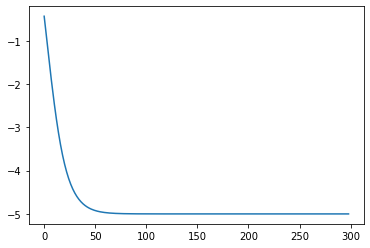

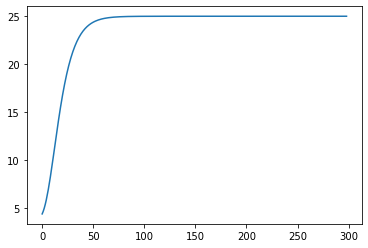

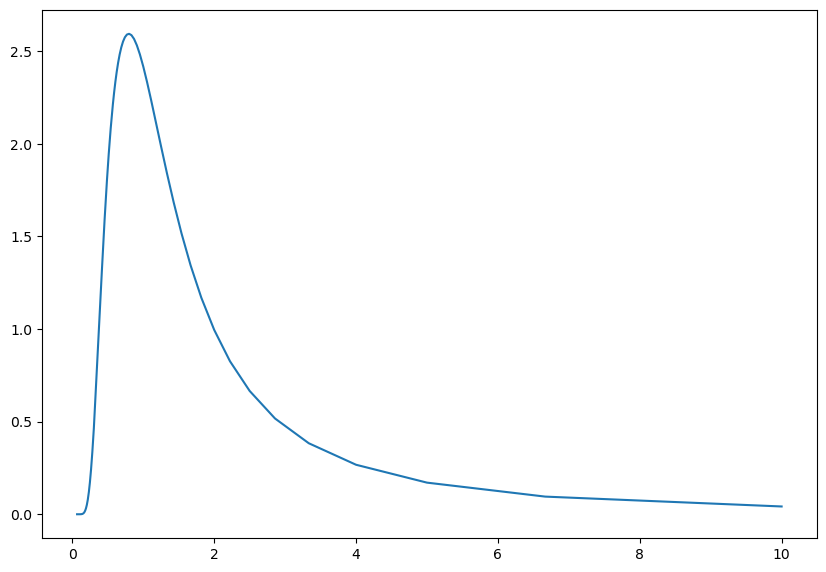

In [56]:
import matplotlib.pyplot as plt
plt.plot(np.mean(Es, axis = 0))
plt.show()
plt.plot(np.mean(E2s, axis = 0))
plt.show()
plt.figure(figsize=(10,7),dpi=100)
plt.plot(1/betas,np.mean(cVs, axis = 0))
plt.show()

The weird behavoir of the heat capacity comes from statistical divergins in the calculation. It appears in some of the times

In [85]:
# spin
m = 200
splitBasis = splitBasisTotZ(genBasis(Lx*Ly,s),Lx,Ly)

beta = 0.05
Nbeta = 300# 300
betas = np.arange(2*beta,beta*(Nbeta + 2),beta)


Es = []
E2s = []
cVs = []
weights = []

for basis in splitBasis:

    zE = []
    zE2 = []
    zCvs = []

    ham = calcMatrix(basis,J,Lx,Ly,s)
    # print(ham)

    if np.shape(ham)[0] > 1:

        weights.append(np.shape(ham)[0])

        ham2 = np.matmul(ham,ham)    
        phi = pullGaussWfFactors(0,1/(np.shape(ham)[0]),np.shape(ham)[0])
        # print(phi)

        phiPrime = realtimeEvolution(ham, beta, Lx,Ly, np.shape(ham)[0], phi)

        E = []
        E2 = []
        cV = []
        cV.append(betas[0]**2*(np.vdot(phiPrime, ham2.dot(phiPrime)) - np.vdot(phiPrime, ham.dot(phiPrime))**2))
        for i in range(1, Nbeta ):
            print(k,i)
            phiPrime = realtimeEvolution(ham, beta, Lx,Ly, m, phiPrime)


        #print(np.vdot(phiPrime, ham2.dot(phiPrime)))

        # print(beta**2*(np.vdot(phiPrime, ham2.dot(phiPrime)) - np.vdot(phiPrime, ham.dot(phiPrime))**2))
            E.append(np.vdot(phiPrime, ham.dot(phiPrime))/norm(phiPrime))
            E2.append(np.vdot(phiPrime, ham2.dot(phiPrime))/norm(phiPrime))
            cV.append((betas[i]**2)*(np.vdot(phiPrime, ham2.dot(phiPrime))/norm(phiPrime) - (np.vdot(phiPrime, ham.dot(phiPrime))/norm(phiPrime))**2))

            phiPrime = phiPrime / norm(phiPrime)

            # print(phiPrime)

        zE.append(E)
        zE2.append(E2)
        zCvs.append(cV)

        Es.append(zE)
        E2s.append(zE2)
        cVs.append(zCvs)

    else:
        weights.append(np.shape(ham)[0])

        ham2 = np.matmul(ham,ham)    
        phi = pullGaussWfFactors(0,1/(np.shape(ham)[0]),np.shape(ham)[0])
        # print(phi)

        phiPrime = np.exp(-beta*ham[0]/2) * phi #realtimeEvolution(ham, beta, Lx,Ly, np.shape(ham)[0], phi)

        E = []
        E2 = []
        cV = []
        cV.append(betas[0]**2*(np.vdot(phiPrime, ham2.dot(phiPrime)) - np.vdot(phiPrime, ham.dot(phiPrime))**2))
        for i in range(1, Nbeta ):
            print(k,i)
            phiPrime = np.exp(-beta*ham[0]/2) * phi# realtimeEvolution(ham, beta, Lx,Ly, m, phiPrime)


        #print(np.vdot(phiPrime, ham2.dot(phiPrime)))

        # print(beta**2*(np.vdot(phiPrime, ham2.dot(phiPrime)) - np.vdot(phiPrime, ham.dot(phiPrime))**2))
            E.append(np.vdot(phiPrime, ham.dot(phiPrime))/norm(phiPrime))
            E2.append(np.vdot(phiPrime, ham2.dot(phiPrime))/norm(phiPrime))
            cV.append((betas[i]**2)*(np.vdot(phiPrime, ham2.dot(phiPrime))/norm(phiPrime) - (np.vdot(phiPrime, ham.dot(phiPrime))/norm(phiPrime))**2))

            phiPrime = phiPrime / norm(phiPrime)

            # print(phiPrime)

        zE.append(E)
        zE2.append(E2)
        zCvs.append(cV)

        Es.append(zE)
        E2s.append(zE2)
        cVs.append(zCvs)


#print(Es)

# energie mit länge des spin sektors gewichten...

1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
1 100
1 101
1 102
1 103
1 104
1 105
1 106
1 107
1 108
1 109
1 110
1 111
1 112
1 113
1 114
1 115
1 116
1 117
1 118
1 119
1 120
1 121
1 122
1 123
1 124
1 125
1 126
1 127
1 128
1 129
1 130
1 131
1 132
1 133
1 134
1 135
1 136
1 137
1 138
1 139
1 140
1 141
1 142
1 143
1 144
1 145
1 146
1 147
1 148
1 149
1 150
1 151
1 152
1 153
1 154
1 155
1 156
1 157
1 158
1 159
1 160
1 161
1 162
1 163
1 164
1 165
1 166
1 167
1 168
1 169
1 170
1 171
1 172
1 173
1 174
1 175
1 176
1 177
1 178
1 179
1 180
1 181
1 182
1 183
1 184
1 18

/tmp/ipykernel_7446/1131574923.py:109: ComplexWarning: Casting complex values to real discards the imaginary part
  v[0] = v0


1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
1 100
1 101
1 102
1 103
1 104
1 105
1 106
1 107
1 108
1 109
1 110
1 111
1 112
1 113
1 114
1 115
1 116
1 117
1 118
1 119
1 120
1 121
1 122
1 123
1 124
1 125
1 126
1 127
1 128
1 129
1 130
1 131
1 132
1 133
1 134
1 135
1 136
1 137
1 138
1 139
1 140
1 141
1 142
1 143
1 144
1 145
1 146
1 147
1 148
1 149
1 150
1 151
1 152
1 153
1 154
1 155
1 156
1 157
1 158
1 159
1 160
1 161
1 162
1 163
1 164
1 165
1 166
1 167
1 168
1 169
1 170
1 171
1 172
1 173
1 174
1 175
1 176
1 177
1 178
1 179
1 180
1 181
1 182
1 183
1 184
1 185
1 186
1 187
1 188
1 189
1 

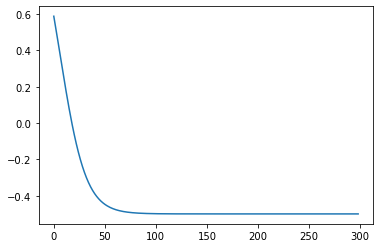

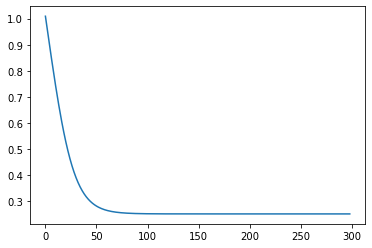

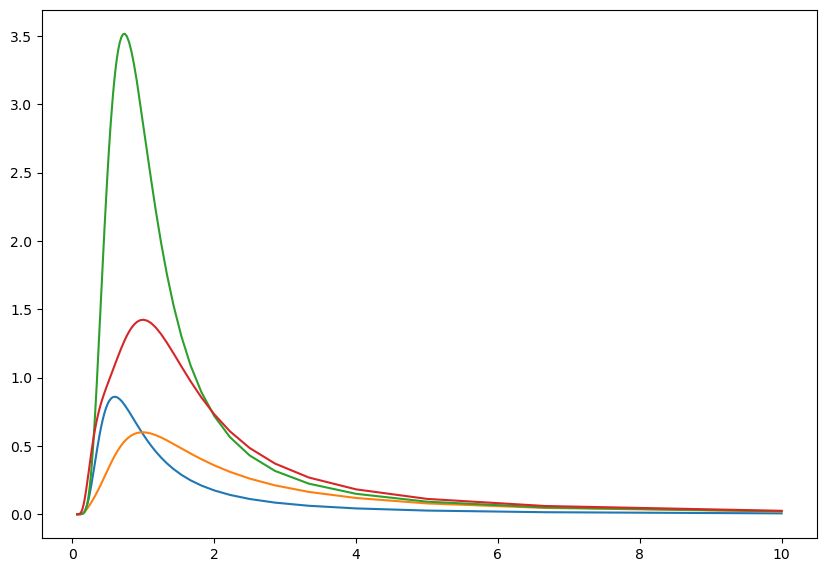

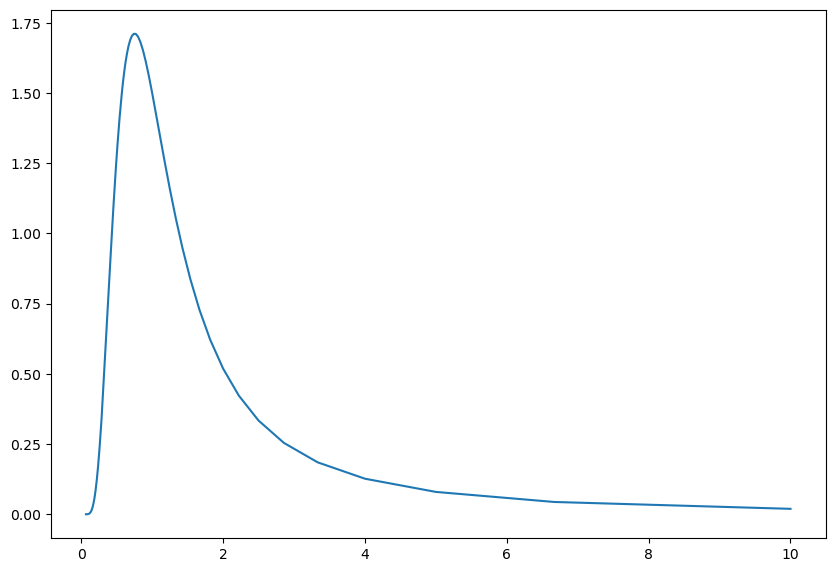

In [86]:
import matplotlib.pyplot as plt
plt.plot(np.mean(Es[1], axis = 0))
plt.show()
plt.plot(np.mean(E2s[1], axis = 0))
plt.show()
plt.figure(figsize=(10,7),dpi=100)
plt.plot(1/betas,cVs[1][0])
plt.plot(1/betas,cVs[2][0])
plt.plot(1/betas,cVs[3][0])
plt.plot(1/betas,cVs[4][0])
plt.show()
plt.figure(figsize=(10,7),dpi=100)
plt.plot(1/betas,np.average(cVs, weights = weights, axis = 0)[0])
plt.show()